## SkyMapper Data Release 2 (DR2) CountCheck


SkyMapper DR2 observattions has range from 2014-03-15(MJD=56730) to 2018-03-14(MJD=58192), contains days of observations, include 121493 images.\
The checked result for row number of each date could be found in skymapper/dr2/date_stat.txt 

In [12]:
import pyvo as vo
import pandas as pd
import numpy as np
import os
#from astropy.time import Time
#from astropy import units as u
from tqdm import tqdm, trange
from math import ceil
#from astropy.time import TimeDelta
import time
import threading
import multiprocessing
import matplotlib.pyplot as plt

**Get expect count number of observations for each day.**\
It seems the timelimit error in skymapper related to the output rows number compare with runtime:
   * COUNT(\*) in each date would definitly fail. 
   * COUNT(\*) in each image_id would fail by 1/10 chance.
   * SELECT object_id in each image_id never fail, but cost longtime to run. 

So the qurey below may not be intuitive version of counting numbers. 

In [ ]:
"""
Thus, straightforward qurey like:
    1) SELECT COUNT(*) FROM DR2.photometry WHERE image_id >= 20140315000000 AND image_id < 20140316000000
    2) SELECT COUNT(*) FROM dr2.photometry as p AND dr2.images as i WHERE p.image_id = i.image_id AND i.date < 56730 AND i.date >= 56729
Are failing directly.
"""
#Get whole image_id list
qurey = """SELECT image_id from dr2.images"""
tap_service = vo.dal.TAPService("https://api.skymapper.nci.org.au/public/tap/")
image_stat = tap_service.search(qurey)
image_stat = pd.DataFrame(image_stat)
image_stat = pd.to_csv("list.csv")

In [ ]:
def force_count(start,end):
    listpd =  pd.read_csv('list.txt', sep=" ")
    for index in range(start,end):
        image_id = listpd["image_id"][index]
        count = 0
        while(True):
            tap_service = vo.dal.TAPService("https://api.skymapper.nci.org.au/public/tap/") 
            #Three possible qurey below:
            
            #try qurey1: short runtime but easy get limitError
            try: 
                qurey1 = f"""SELECT COUNT(*) FROM dr2.photometry WHERE image_id = {image_id} """
                each_image = tap_service.search(qurey1)
                each_image = pd.DataFrame(each_image)
                count = each_image["count_all"][0]
                break
            except vo.dal.exceptions.DALQueryError:
                file = open("errormessage.txt", "a")  
                file.write(f"{image_id:.0f} qurey1 failed\n")
                file.close()
            #try qurey2: medium runtime, fair get limitError
            try: 
                qurey2 = f"""SELECT MAX(object_id_local) FROM dr2.photometry WHERE image_id = {image_id} GROUP BY ccd"""
                each_max = tap_service.search(qurey2)
                each_max = pd.DataFrame(each_max)
                count = each_max["max"].sum()
                break
            except vo.dal.exceptions.DALQueryError:
                file = open("errormessage.txt", "a")  
                file.write(f"{image_id:.0f} qurey2 failed\n")
                file.close()
            #try qurey3: long time to qurey, hardest to get error
            try: 
                qurey3 = f"""SELECT object_id FROM dr2.photometry WHERE image_id = {image_id}"""
                all_object = tap_service.search(qurey3)
                all_object = pd.DataFrame(all_object)
                count = all_object.shape[0]
                break
            except vo.dal.exceptions.DALQueryError:
                file = open("errormessage.txt", "a")  
                file.write(f"{image_id:.0f} qurey3 failed\n")
                file.close()

         # Wirte to result 
        file = open("result.txt", "a") 
        file.write(f"{image_id} {count}\n")
        file.close()

In [ ]:
jobs = []
listpd =  pd.read_csv('list.txt', sep=" ")
Slice = ceil (listpd.shape[0] / 20)
for i in range(20):
	process = multiprocessing.Process(target=force_count, args=(Slice * i, Slice * (i+1)))
	jobs.append(process)

for j in jobs: 
	j.start()

for j in jobs:
	j.join()

In [ ]:
df = pd.read_csv('result.txt', sep=" ")
df = df.drop(columns=['index'])
df = df.sort_values(by='image_id')
df = df.astype({"image_id": str}, errors='raise') 
df['date'] = df['image_id'].str.slice(0, 9)
df['date'] = [f"{y}-{m}-{d}" for y,m, d in zip(df['date'].str.slice(0, 4), df['date'].str.slice(4, 6),df['date'].str.slice(6, 8))]
df2 = df.drop(columns=['image_id'])
df2 = df2.groupby(['date']).sum()
df2.to_csv("refer.csv")

**Get actual row numbers in database**

In [ ]:
#56730,58192
for index in range(56730,58192):
    date = Time(index, format='mjd') #Timeobject
    date = date.to_value('iso',subfmt='date') #String formate 2014-03-20
    DATA_DIR = "/epyc/projects/adam_datasets/skyMapper_dr2/data_test"
    file_name = os.path.join(DATA_DIR, f"dr2_observations_{date}.h5")
    if(not os.path.isfile(file_name)):
        continue
        
    store = pd.HDFStore(file_name, mode = "r")
    qurey_num = store.get_storer('data').nrows
    store.close() 
    
    file = open("qureyNum.txt", "a")  # append mode
    file.write(f"{date},{qurey_num}\n")
    file.close()

**Compare expected and actual and statstic**

/tmp/ipykernel_122136/2359644383.py:4: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


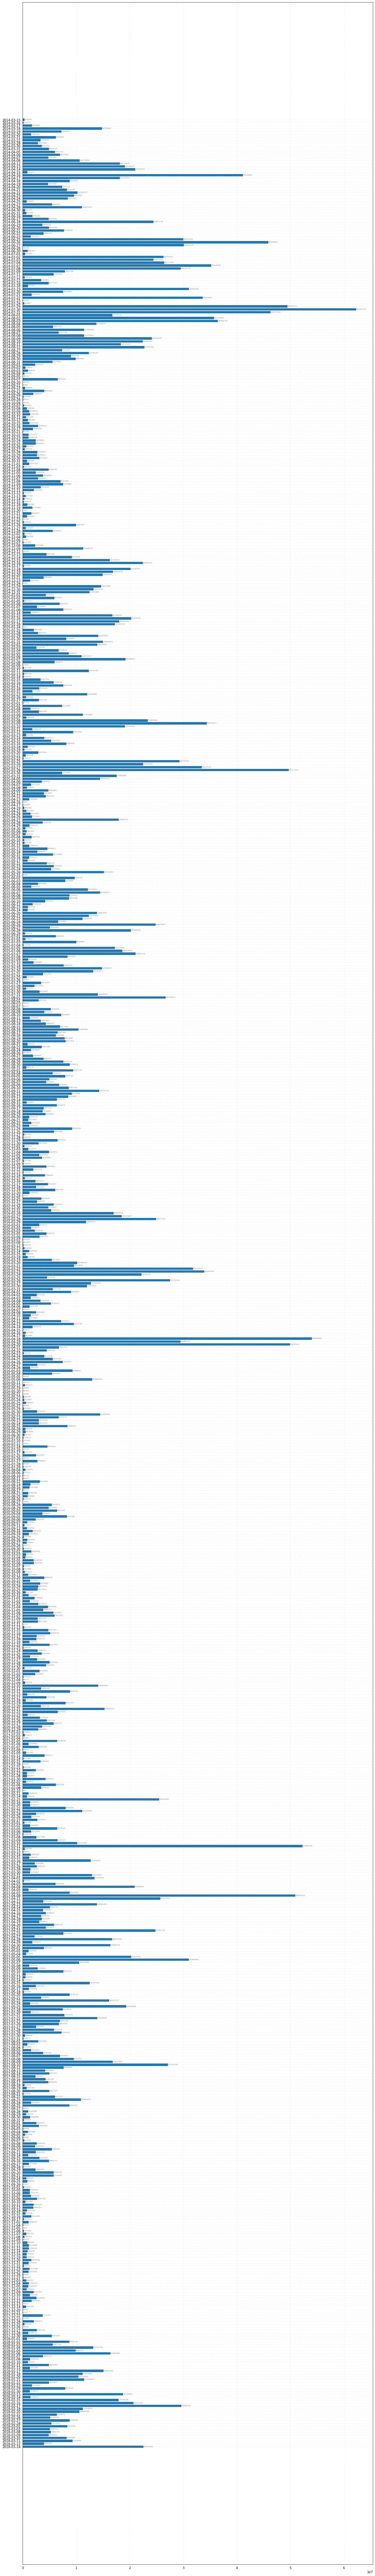

In [28]:
expected = pd.read_csv("refer.csv")
fig, ax = plt.subplots(figsize =(20, 150))
ax.barh(expected['date'], expected['count'])
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 6,color ='grey')
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.invert_yaxis()
plt.show()